In [1]:
import pandas as pd
import numpy as np

import csv   
import math
import matplotlib.pyplot as plt
import datetime

import librosa as lr
import librosa.display as lrd
%matplotlib inline
%load_ext rpy2.ipython

In [2]:
SPLIT_TRAIN_TEST = .8
TARGET_FILE = '../data/noisemaker_light/noisemaker_light.csv'
SAMPLES_FOLDER = '../data/noisemaker_light/noisemaker_light_samples/'
FOLDER_PREFIX = 'noisemaker_light'

D = str(datetime.datetime.now())
RESULTS_FILE = 'RESULTS-' + FOLDER_PREFIX + '-' + D[:16].replace(' ','_') + '.csv'
print RESULTS_FILE

HOP_LENGTH = 512

N_MFCC = 20
N_MEL = 32

N_EPOCHS = 10
BATCH_SIZE = 43
VERBOSE = 1
VALIDATION = .1

RESULTS-noisemaker_light-2018-01-09_11:16.csv


# Prepares datasets

In [3]:
# Prepares labels
Y = pd.read_csv(TARGET_FILE)
print Y.head()

len_train = int(Y.shape[0]*.8)
len_test = int(Y.shape[0]*.2)
print len_train, len_test

Y_train = Y.iloc[:len_train,:]
Y_test = Y.iloc[len_train:,:]
print 
print 'Training data:', Y_train.shape
print 'Test data:', Y_test.shape

Y_train, files_train =  Y_train.drop('file', axis=1), Y_train['file']
Y_test, files_test = Y_test.drop('file', axis=1), Y_test['file']
print
print files_train[:5]
print files_test[:5]

   lfo1_rate  filter_cutoff  lfo1_amount osc2_wave  filter_resonance    file
0   0.629921       1.811024     2.755906      Sine          1.653543  s0.wav
1   8.818898       1.496063     1.653543      Sine          3.464567  s1.wav
2   5.590551       8.346457     5.118110     Pulse          4.251969  s2.wav
3   6.535433       9.291339     5.748031       Saw          5.039370  s3.wav
4   9.212598       0.078740     4.803150     Pulse          6.614173  s4.wav
800 200

Training data: (800, 6)
Test data: (200, 6)

0    s0.wav
1    s1.wav
2    s2.wav
3    s3.wav
4    s4.wav
Name: file, dtype: object
800    s800.wav
801    s801.wav
802    s802.wav
803    s803.wav
804    s804.wav
Name: file, dtype: object


In [4]:
# Loads waveforms
sampling_rate = lr.load(SAMPLES_FOLDER + files_train[0])[1]
print 'Sampling rate:', sampling_rate

waveforms_test = []
for i, file_name in enumerate(files_test):
    if i % 100 == 0:
        print 'Loaded testing waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_test.append(lr.load(f)[0])
X_test = np.stack(waveforms_test)
print X_test.shape


waveforms_train = []
for i, file_name in enumerate(files_train):
    if i % 100 == 0:
        print 'Loaded training waveform #' + str(i)
    f = SAMPLES_FOLDER + file_name
    waveforms_train.append(lr.load(f)[0])
X_train = np.stack(waveforms_train)
print X_train.shape

Sampling rate: 22050
Loaded testing waveform #0
Loaded testing waveform #100
(200, 19845)
Loaded training waveform #0
Loaded training waveform #100
Loaded training waveform #200
Loaded training waveform #300
Loaded training waveform #400
Loaded training waveform #500
Loaded training waveform #600
Loaded training waveform #700
(800, 19845)


# Independent models

## Prepares the features

In [5]:
L_test_mfcc = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_test_mfcc.append(mfcc)
X_test_mfcc = np.stack(L_test_mfcc)
print X_test_mfcc.shape

L_train_mfcc = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mfcc = lr.feature.mfcc(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mfcc=N_MFCC)
    L_train_mfcc.append(mfcc)
X_train_mfcc = np.stack(L_train_mfcc)
print X_train_mfcc.shape

(200, 20, 39)
(800, 20, 39)


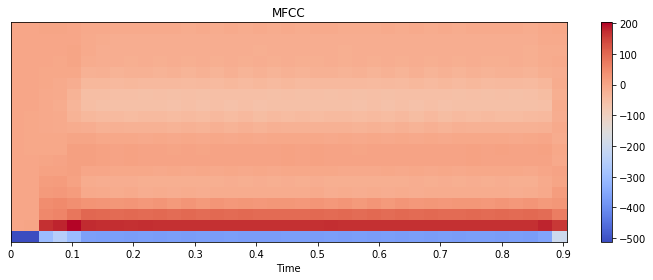

In [6]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mfcc[140,...], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()

In [7]:
X_test_mfcc = np.reshape(X_test_mfcc, (X_test_mfcc.shape[0],-1))
X_train_mfcc = np.reshape(X_train_mfcc, (X_train_mfcc.shape[0],-1))
print X_test_mfcc.shape
print X_train_mfcc.shape

(200, 780)
(800, 780)


## Predictions

In [8]:
import sys
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,mean_absolute_error
from sklearn.model_selection import GridSearchCV

headers=['algo', 'type', 'param1','param2','regularization',
         'target','metric', 'train_score', 'test_score']
with open(RESULTS_FILE, 'w') as f:
    writer = csv.writer(f)
    writer.writerow(headers)

def evaluate_algo(algo_label, grid_reg, grid_class):
    results = []
    for t_i, t_name in enumerate(list(Y_train)):
        print 'predicting feature', t_name
        y_train = Y_train[[t_name]].values.flatten()
        y_test = Y_test[[t_name]].values.flatten()
        print y_train.dtype
        
        best_params_C = None
        best_params_R = None
        
        try:
            # Case 1: classification
            if y_train.dtype == 'object':

                metric = 'class'

                # Cross-Validation Score
                grid_class.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_class.best_score_
                best_params_C = grid_class.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_class.predict(X_test_mfcc)
                test_score = accuracy_score(test_pred, y_test)
                print test_score


            # Case 2: regression
            elif y_train.dtype == 'float64':

                metric = 'reg'

                # Cross-Validation Score
                grid_reg.fit(X_train_mfcc, y_train)
                cross_val_scores = grid_reg.best_score_ * -1
                best_params_R = grid_reg.best_params_
                print cross_val_scores

                # Test Score
                test_pred = grid_reg.predict(X_test_mfcc)
                test_score = mean_absolute_error(test_pred, y_test)
                print test_score

            else:
                raise ValueError('Wrong Column Type')

            out = (algo_label, 'per_output', best_params_R, best_params_C,None,
                   t_name, metric, cross_val_scores, test_score)
            print out
            with open(RESULTS_FILE, 'a') as f:
                writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
                writer.writerow(out)

        except:
            print "Unexpected error:", sys.exc_info()[0]

In [9]:
from sklearn import neighbors

algo_C =neighbors.KNeighborsClassifier()
grid_C = GridSearchCV(algo_C, {"n_neighbors":[3,5,8,16]}, scoring='accuracy', verbose=2)

algo_R =neighbors.KNeighborsRegressor()
grid_R = GridSearchCV(algo_R, {"n_neighbors":[3,5,8,16]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('kNN', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.2s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.2s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.2s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.4s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.2s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    4.0s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.7s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.7s finished


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=3 ...................................................
[CV] .................................... n_neighbors=3, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=5 ...................................................
[CV] .................................... n_neighbors=5, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .................................... n_neighbors=8, total=   0.1s
[CV] n_neighbors=8 ...................................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed:    3.6s finished


In [10]:
from sklearn import tree

algo_C = tree.DecisionTreeClassifier()
grid_C = GridSearchCV(algo_C, {"max_depth":[2,4,8,16,32,64,128]}, scoring='accuracy', verbose=2)

algo_R = tree.DecisionTreeRegressor()
grid_R = GridSearchCV(algo_R, {"max_depth":[2,4,8,16,32,64,128]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Decision Tree', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.3s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    5.6s finished


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    5.4s finished


1.43857249812
1.57903703726
('Decision Tree', 'per_output', {'max_depth': 4}, None, 'filter_cutoff', 'reg', 1.4385724981216632, 1.5790370372643769)
predicting feature lfo1_amount
float64
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.3s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    5.4s finished


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] ..................................... max_depth=16, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    4.2s finished


0.8875
0.85
('Decision Tree', 'per_output', None, {'max_depth': 8}, 'osc2_wave', 'class', 0.88749999999999996, 0.84999999999999998)
predicting feature filter_resonance
float64
Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................
[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=2 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ...................................... max_depth=2, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.1s
[CV] max_depth=4 .....................................................
[CV] ...................................... max_depth=4, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.3s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=8, total=   0.2s
[CV] max_depth=16 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  21 out of  21 | elapsed:    6.0s finished


2.20272703053
2.21716791991
('Decision Tree', 'per_output', {'max_depth': 4}, None, 'filter_resonance', 'reg', 2.2027270305302027, 2.217167919908428)


In [11]:
from sklearn import dummy

algo_C = dummy.DummyClassifier()
grid_C = GridSearchCV(algo_C, {"strategy":["most_frequent"]}, scoring='accuracy', verbose=2)

algo_R = dummy.DummyRegressor()
grid_R = GridSearchCV(algo_R, {"strategy":["mean"]}, scoring='neg_mean_absolute_error', verbose=2)

evaluate_algo('Naive', grid_R, grid_C)

predicting feature lfo1_rate
float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
2.47532804526
2.6774015748
('Naive', 'per_output', {'strategy': 'mean'}, None, 'lfo1_rate', 'reg', 2.4753280452584878, 2.6774015748033846)
predicting feature filter_cutoff
float64
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] strategy=mean ...................................................
[CV] .................................... strategy=mean, total=   0.0s
[CV] strategy=mean ...................................................
[CV] .....................

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


In [12]:
# from sklearn import svm

# algo_R = svm.SVR(kernel='linear')
# grid_R = GridSearchCV(algo_R, {'C':[.01, .1, 1.]},
#                       scoring='neg_mean_absolute_error', verbose=2,
#                      n_jobs =4)

# algo_C = svm.SVC(kernel='linear')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1.]},
#                       scoring='accuracy', verbose=2,
#                       n_jobs =4)


# evaluate_algo('SVM_lin', grid_R, grid_C)

# algo_R = svm.SVR(kernel='RBF')
# grid_R = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='neg_mean_absolute_error', verbose=2)

# algo_C = svm.SVC(kernel='RBF')
# grid_C = GridSearchCV(algo_C, {'C':[.01, .1, 1]},
#                       scoring='accuracy', verbose=2)


# evaluate_algo('SVM_RBF', grid_R, grid_C)

# Joint modelling + mid-level features

In [27]:
def target_info(df_y):
    infos = {}
    
    for i,name in enumerate(list(df_y)):
        print name
        
        y = df_y[[name]].values.flatten()
        infos[name] = {'type':y.dtype}
        
        if y.dtype=='object':
            u_vals = sorted(np.unique(y))
            infos[name]['int2char'] = {i:v for i,v in enumerate(u_vals)}
            infos[name]['char2int'] = {v:i for i,v in enumerate(u_vals)}
            
        elif y.dtype=='float64':
            infos[name]['mean'] = np.mean(y)
            infos[name]['sd'] = np.std(y)
        
    return infos

# Gets target info
Y_info = target_info(Y_train)
print Y_info

lfo1_rate
filter_cutoff
lfo1_amount
osc2_wave
filter_resonance
{'lfo1_rate': {'sd': 2.8756837733162297, 'type': dtype('float64'), 'mean': 5.064960629921563}, 'filter_cutoff': {'sd': 2.89234557524474, 'type': dtype('float64'), 'mean': 5.0103346456694338}, 'osc2_wave': {'char2int': {'Sine': 3, 'Noise': 0, 'Saw': 2, 'Triangle': 4, 'Pulse': 1}, 'int2char': {0: 'Noise', 1: 'Pulse', 2: 'Saw', 3: 'Sine', 4: 'Triangle'}, 'type': dtype('O')}, 'lfo1_amount': {'sd': 2.932316237542842, 'type': dtype('float64'), 'mean': 4.9543307086615656}, 'filter_resonance': {'sd': 2.9479893137687894, 'type': dtype('float64'), 'mean': 5.0626968503939489}}


In [28]:
L_test_mel = []
for i in range(X_test.shape[0]):
    S = X_test[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_test_mel.append(mel)
X_test_mel = np.stack(L_test_mel)
print X_test_mel.shape

L_train_mel = []
for i in range(X_train.shape[0]):
    S = X_train[i,:]
    mel = lr.feature.melspectrogram(y=S, sr=sampling_rate, hop_length=HOP_LENGTH, n_mels=N_MEL)
    L_train_mel.append(mel)
X_train_mel = np.stack(L_train_mel)
print X_train_mel.shape

(200, 32, 39)
(800, 32, 39)


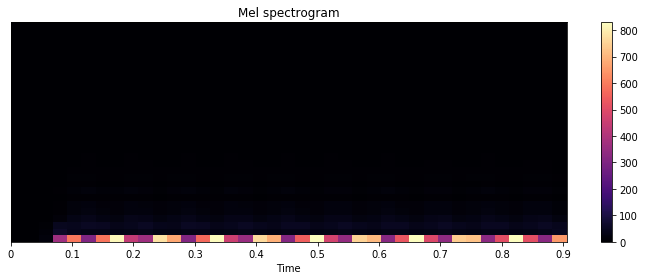

In [29]:
plt.figure(figsize=(10, 4))
lr.display.specshow(X_train_mel[1,...], x_axis='time')
plt.colorbar()
plt.title('Mel spectrogram')
plt.tight_layout()

In [30]:
X_train_mel = np.transpose(X_train_mel, (0,2,1))
X_test_mel = np.transpose(X_test_mel, (0,2,1))
print X_train_mel.shape, X_test_mel.shape

(800, 39, 32) (200, 39, 32)


In [36]:
def format_output(Y):
    out = {}
    for name,infos in Y_info.iteritems():
        if infos['type'] == 'float64':
            y = (Y[name] - infos['mean']) / infos['sd']
            
        elif infos['type'] == 'object':
            char2int = infos['char2int']
            y = np.zeros((len(Y[name]), len(char2int)))
            for i,yval in enumerate(Y[name]):
                y[i, char2int[yval]] = 1
                
        else:
            raise ValueError
        
        print name, y.shape
        out[name] = y
    
    return out

        
def test_model(label, params1, params2, regul, model):
    
    # Prepares input and output data
    X_mean = np.mean(X_train_mel, axis=(0))
    X_sd = np.std(X_train_mel, axis=(0))
    
    X_train = (X_train_mel - X_mean) / X_sd
    X_test  = (X_test_mel - X_mean) / X_sd
    
    Y_dict_train = format_output(Y_train)
    Y_dict_test  = format_output(Y_test)
    
    # Trains the model
    hist = model.fit(X_train, Y_dict_train, 
              epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=VERBOSE,
             validation_split = VALIDATION)
    
    # Makes predictions
    pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    
    # Gets validation and test scores (for each metric)
    Y = {}
    for j, Y_pred in enumerate(pred):
        t_name = Y_info.keys()[j]
        t_infos = Y_info[t_name]
        
        print t_name
        print Y_pred.shape

        if t_infos['type'] == 'float64':
            test_metric = 'reg'
            Y_pred = Y_pred.flatten()
            y_pred = Y_pred * t_infos['sd'] + t_infos['mean']
            y_pred = y_pred.tolist()
            test_score = mean_absolute_error(y_pred, Y_test[t_name])
        
        elif t_infos['type'] == 'object':
            test_metric = 'class'
            y_i = np.argmax(Y_pred, axis=1)
            y_pred = [t_infos['int2char'][y] for y in y_i]
            test_score = accuracy_score(y_pred, Y_test[t_name])

        else:
            raise ValueError
        
        #train_scores = hist.history[t_name + '_loss'][-1]
        train_scores = -1 * hist.history['loss'][-1]
        out = (label, 'joint', params1, params2, regul,
               t_name, test_metric, train_scores, test_score)
        print out
        with open(RESULTS_FILE, 'a') as f:
            writer = csv.writer(f,quoting=csv.QUOTE_NONNUMERIC)
            writer.writerow(out)

        Y[t_name] = y_pred
    
    Y = pd.DataFrame(Y)
    return Y

In [38]:
# Model 1: 1 layer perceptron
from keras.layers import Input, Dense, Flatten
from keras.models import Model
from keras import regularizers

def MLP(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = Flatten()(in_layer)
    for i in range(n_layers):
        h_layer = Dense(n_hidden_units, activation='relu')(h_layer)

    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name, 
                              kernel_regularizer=regularizers.l2(regul))(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, kernel_regularizer=regularizers.l2(regul),
                              activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [8,16,32,64]:
        for REGUL in [0,0.01,0.1,1]:
            model = MLP(N_UNITS, N_LAYERS, REGUL)
            out = test_model('MLP', N_UNITS, N_LAYERS, REGUL, model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_30 (InputLayer)           (None, 39, 32)       0                                            
__________________________________________________________________________________________________
flatten_10 (Flatten)            (None, 1248)         0           input_30[0][0]                   
__________________________________________________________________________________________________
dense_20 (Dense)                (None, 8)            9992        flatten_10[0][0]                 
__________________________________________________________________________________________________
lfo1_rate (Dense)               (None, 1)            9           dense_20[0][0]                   
__________________________________________________________________________________________________
filter_cut

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 5s 7ms/step - loss: 6.6125 - lfo1_rate_loss: 1.1645 - filter_cutoff_loss: 1.0442 - osc2_wave_loss: 1.8073 - lfo1_amount_loss: 1.0892 - filter_resonance_loss: 1.3508 - val_loss: 5.5201 - val_lfo1_rate_loss: 1.0966 - val_filter_cutoff_loss: 0.8382 - val_osc2_wave_loss: 1.4200 - val_lfo1_amount_loss: 0.9620 - val_filter_resonance_loss: 1.0496
Epoch 2/10
720/720 [==============================] - 0s 131us/step - loss: 5.6939 - lfo1_rate_loss: 1.0262 - filter_cutoff_loss: 0.9044 - osc2_wave_loss: 1.5289 - lfo1_amount_loss: 0.9941 - filter_resonance_loss: 1.0884 - val_loss: 5.2283 - val_lfo1_rate_loss: 1.0990 - val_filter_cutoff_loss: 0.7048 - val_osc2_wave_loss: 1.3364 - val_lfo1_amount_loss: 0.9154 - val_filter_resonance_loss: 1.0229
Epoch 3/10
720/720 [==============================] - 0s 112us/step - loss: 5.1377 - lfo1_rate_loss: 0.9491 - filter_cutoff_loss: 0.7890 - osc2_wave_loss: 1.3883

720/720 [==============================] - 0s 116us/step - loss: 5.6340 - lfo1_rate_loss: 0.8577 - filter_cutoff_loss: 0.7666 - osc2_wave_loss: 1.2598 - lfo1_amount_loss: 0.8567 - filter_resonance_loss: 0.8431 - val_loss: 5.6646 - val_lfo1_rate_loss: 0.9663 - val_filter_cutoff_loss: 0.7227 - val_osc2_wave_loss: 1.3026 - val_lfo1_amount_loss: 0.8705 - val_filter_resonance_loss: 0.7770
Epoch 5/10
720/720 [==============================] - 0s 100us/step - loss: 5.4693 - lfo1_rate_loss: 0.8467 - filter_cutoff_loss: 0.7468 - osc2_wave_loss: 1.2192 - lfo1_amount_loss: 0.8300 - filter_resonance_loss: 0.8215 - val_loss: 5.5939 - val_lfo1_rate_loss: 0.9545 - val_filter_cutoff_loss: 0.7438 - val_osc2_wave_loss: 1.2989 - val_lfo1_amount_loss: 0.8666 - val_filter_resonance_loss: 0.7483
Epoch 6/10
720/720 [==============================] - 0s 133us/step - loss: 5.3495 - lfo1_rate_loss: 0.8477 - filter_cutoff_loss: 0.7495 - osc2_wave_loss: 1.1646 - lfo1_amount_loss: 0.8160 - filter_resonance_loss: 0

720/720 [==============================] - 0s 133us/step - loss: 12.5187 - lfo1_rate_loss: 0.8037 - filter_cutoff_loss: 0.6772 - osc2_wave_loss: 1.3888 - lfo1_amount_loss: 0.9157 - filter_resonance_loss: 0.7816 - val_loss: 12.3844 - val_lfo1_rate_loss: 0.8133 - val_filter_cutoff_loss: 0.6969 - val_osc2_wave_loss: 1.4514 - val_lfo1_amount_loss: 0.9980 - val_filter_resonance_loss: 0.7707
Epoch 8/10
720/720 [==============================] - 0s 137us/step - loss: 11.9276 - lfo1_rate_loss: 0.7886 - filter_cutoff_loss: 0.6655 - osc2_wave_loss: 1.3789 - lfo1_amount_loss: 0.9051 - filter_resonance_loss: 0.7821 - val_loss: 11.7945 - val_lfo1_rate_loss: 0.8041 - val_filter_cutoff_loss: 0.6982 - val_osc2_wave_loss: 1.4362 - val_lfo1_amount_loss: 0.9502 - val_filter_resonance_loss: 0.7777
Epoch 9/10
720/720 [==============================] - 0s 157us/step - loss: 11.3615 - lfo1_rate_loss: 0.7768 - filter_cutoff_loss: 0.6424 - osc2_wave_loss: 1.3666 - lfo1_amount_loss: 0.9024 - filter_resonance_lo

200/200 [==============================] - 2s 8ms/step
lfo1_rate
(200, 1)
('MLP', 'joint', 16, 1, 0, 'lfo1_rate', 'reg', -3.4436859104368422, 2.9945957973531527)
filter_cutoff
(200, 1)
('MLP', 'joint', 16, 1, 0, 'filter_cutoff', 'reg', -3.4436859104368422, 2.0162724442838775)
osc2_wave
(200, 5)
('MLP', 'joint', 16, 1, 0, 'osc2_wave', 'class', -3.4436859104368422, 0.77000000000000002)
lfo1_amount
(200, 1)
('MLP', 'joint', 16, 1, 0, 'lfo1_amount', 'reg', -3.4436859104368422, 3.0336213450636706)
filter_resonance
(200, 1)
('MLP', 'joint', 16, 1, 0, 'filter_resonance', 'reg', -3.4436859104368422, 2.5688028708686317)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 39, 32)       0                                            
____________________________________________________________________________________

Train on 720 samples, validate on 80 samples
Epoch 1/10
720/720 [==============================] - 5s 7ms/step - loss: 8.0000 - lfo1_rate_loss: 1.1408 - filter_cutoff_loss: 0.9504 - osc2_wave_loss: 1.6931 - lfo1_amount_loss: 1.1268 - filter_resonance_loss: 1.4010 - val_loss: 6.5272 - val_lfo1_rate_loss: 0.8986 - val_filter_cutoff_loss: 0.7122 - val_osc2_wave_loss: 1.3333 - val_lfo1_amount_loss: 0.9056 - val_filter_resonance_loss: 1.0394
Epoch 2/10
720/720 [==============================] - 0s 128us/step - loss: 6.8250 - lfo1_rate_loss: 0.9471 - filter_cutoff_loss: 0.7742 - osc2_wave_loss: 1.3398 - lfo1_amount_loss: 1.0327 - filter_resonance_loss: 1.1341 - val_loss: 6.2324 - val_lfo1_rate_loss: 0.8937 - val_filter_cutoff_loss: 0.7232 - val_osc2_wave_loss: 1.2324 - val_lfo1_amount_loss: 0.9117 - val_filter_resonance_loss: 0.9206
Epoch 3/10
720/720 [==============================] - 0s 173us/step - loss: 6.2020 - lfo1_rate_loss: 0.8510 - filter_cutoff_loss: 0.7417 - osc2_wave_loss: 1.1374

720/720 [==============================] - 0s 143us/step - loss: 15.9610 - lfo1_rate_loss: 0.8573 - filter_cutoff_loss: 0.7102 - osc2_wave_loss: 1.1363 - lfo1_amount_loss: 0.8340 - filter_resonance_loss: 0.8233 - val_loss: 15.5733 - val_lfo1_rate_loss: 0.9555 - val_filter_cutoff_loss: 0.6655 - val_osc2_wave_loss: 1.2207 - val_lfo1_amount_loss: 0.8016 - val_filter_resonance_loss: 0.8759
Epoch 5/10
720/720 [==============================] - 0s 141us/step - loss: 14.8589 - lfo1_rate_loss: 0.8619 - filter_cutoff_loss: 0.6801 - osc2_wave_loss: 1.1023 - lfo1_amount_loss: 0.8280 - filter_resonance_loss: 0.7779 - val_loss: 14.5222 - val_lfo1_rate_loss: 0.9427 - val_filter_cutoff_loss: 0.6550 - val_osc2_wave_loss: 1.1853 - val_lfo1_amount_loss: 0.7883 - val_filter_resonance_loss: 0.8422
Epoch 6/10
720/720 [==============================] - 0s 124us/step - loss: 13.8188 - lfo1_rate_loss: 0.8142 - filter_cutoff_loss: 0.6481 - osc2_wave_loss: 1.0596 - lfo1_amount_loss: 0.8127 - filter_resonance_lo

Epoch 7/10
720/720 [==============================] - 0s 132us/step - loss: 3.4404 - lfo1_rate_loss: 0.8450 - filter_cutoff_loss: 0.6374 - osc2_wave_loss: 0.4745 - lfo1_amount_loss: 0.8106 - filter_resonance_loss: 0.6729 - val_loss: 3.7672 - val_lfo1_rate_loss: 0.9052 - val_filter_cutoff_loss: 0.6786 - val_osc2_wave_loss: 0.5212 - val_lfo1_amount_loss: 0.9076 - val_filter_resonance_loss: 0.7546
Epoch 8/10
720/720 [==============================] - 0s 137us/step - loss: 3.2528 - lfo1_rate_loss: 0.7998 - filter_cutoff_loss: 0.5727 - osc2_wave_loss: 0.4467 - lfo1_amount_loss: 0.7749 - filter_resonance_loss: 0.6587 - val_loss: 3.7299 - val_lfo1_rate_loss: 0.8363 - val_filter_cutoff_loss: 0.6721 - val_osc2_wave_loss: 0.4904 - val_lfo1_amount_loss: 0.9561 - val_filter_resonance_loss: 0.7749
Epoch 9/10
720/720 [==============================] - 0s 133us/step - loss: 3.1429 - lfo1_rate_loss: 0.7607 - filter_cutoff_loss: 0.5691 - osc2_wave_loss: 0.4152 - lfo1_amount_loss: 0.7693 - filter_resona

200/200 [==============================] - 2s 9ms/step
lfo1_rate
(200, 1)
('MLP', 'joint', 32, 1, 0.01, 'lfo1_rate', 'reg', -3.1500589821073746, 2.8562223805126665)
filter_cutoff
(200, 1)
('MLP', 'joint', 32, 1, 0.01, 'filter_cutoff', 'reg', -3.1500589821073746, 2.0096027267356034)
osc2_wave
(200, 5)
('MLP', 'joint', 32, 1, 0.01, 'osc2_wave', 'class', -3.1500589821073746, 0.84999999999999998)
lfo1_amount
(200, 1)
('MLP', 'joint', 32, 1, 0.01, 'lfo1_amount', 'reg', -3.1500589821073746, 2.9452797643217146)
filter_resonance
(200, 1)
('MLP', 'joint', 32, 1, 0.01, 'filter_resonance', 'reg', -3.1500589821073746, 2.3638823448670987)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_40 (InputLayer)           (None, 39, 32)       0                                            
_____________________________________________________________________

KeyboardInterrupt: 

In [39]:
from keras.layers import LSTM

def modLSTM(n_hidden_units, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        seq = i < n_layers - 1
        h_layer = LSTM(n_hidden_units, return_sequences=seq, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_LAYERS in [1,2]:
    for N_UNITS in [4,8,16,32,64,128,256]:
        for REGUL in [0,0.01,0.1,1]:
            model = modLSTM(N_UNITS, N_LAYERS, REGUL)
            out = test_model('LSTM', N_UNITS, N_LAYERS, REGUL, model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 39, 32)       0                                            
__________________________________________________________________________________________________
lstm_22 (LSTM)                  (None, 4)            592         input_41[0][0]                   
__________________________________________________________________________________________________
lfo1_rate (Dense)               (None, 1)            5           lstm_22[0][0]                    
__________________________________________________________________________________________________
filter_cutoff (Dense)           (None, 1)            5           lstm_22[0][0]                    
__________________________________________________________________________________________________
osc2_wave 

Train on 720 samples, validate on 80 samples
Epoch 1/10


KeyboardInterrupt: 

In [ ]:
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D

W = 4

def modConvo(n_filters, n_layers, regul):
    # Input layer
    in_shape = (X_test_mel.shape[1],X_test_mel.shape[2])
    print in_shape
    in_layer = Input(shape=in_shape)
    
    # Hidden layers
    h_layer = in_layer
    for i in range(n_layers):
        print i
        conv_layer = Conv1D(n_filters*(i+1), W, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer)
        h_layer = MaxPooling1D(W, strides=2)(conv_layer)
    
    h_layer_pool = GlobalMaxPooling1D()(h_layer)
    h_layer_full = Dense(n_filters, 
                          kernel_regularizer=regularizers.l2(regul))(h_layer_pool)
    
    # Output layers and losses
    out_layers = []
    losses = {}
    metrics = {}
    for name,infos in Y_info.iteritems():
        
        if infos['type'] == 'float64':
            out_layer = Dense(1, name=name)(h_layer_full)
            losses[name] = 'mean_absolute_error'
            metrics[name] = 'mean_absolute_error'
            
        elif infos['type'] == 'object':
            out_dim = len(infos['char2int'])
            out_layer = Dense(out_dim, activation='softmax', name=name)(h_layer_full)
            losses[name] = 'categorical_crossentropy'
            metrics[name] = 'accuracy'

        else:
            raise ValueError
        out_layers.append(out_layer)

    model = Model(inputs = in_layer, outputs = out_layers)
    model.compile(loss=losses, optimizer='adam')
    
    print model.summary()
    return model

for N_FILTERS in [8,16,32]:
    for N_LAYERS in [1,2]:
        for REGUL in [0,0.01,0.1,1]:
            model = modConvo(N_FILTERS, N_LAYERS, REGUL)
            out = test_model('Conv', N_FILTERS, N_LAYERS, REGUL, model)

(39, 32)
0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_43 (InputLayer)           (None, 39, 32)       0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 36, 8)        1032        input_43[0][0]                   
__________________________________________________________________________________________________
max_pooling1d_10 (MaxPooling1D) (None, 17, 8)        0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
global_max_pooling1d_7 (GlobalM (None, 8)            0           max_pooling1d_10[0][0]           
__________________________________________________________________________________________________

Train on 720 samples, validate on 80 samples
Epoch 1/10


# Visualizing the results

/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr

  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Conflicts with tidy packages ---------------------------------------------------

  warnings.warn(x, RRuntimeWarning)
/Users/thib/.virtualenvs/mir/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: filter(): dplyr, stats
lag():    dplyr, stats

  warnings.warn(x, RRuntimeWarning)


  algo  type algo_instance_reg algo_instance_class train_score
1 Conv joint                32                   1   -3.603577
2 LSTM joint               128                   2   -2.931355
3  MLP joint                64                   2   -2.753607
            algo metric    score
1           Conv  class 0.780000
2           Conv    reg 2.497921
3  Decision Tree  class 0.850000
4  Decision Tree    reg 2.213497
5           LSTM  class 0.750000
6           LSTM    reg 2.131865
7            MLP  class 0.825000
8            MLP    reg 2.400132
9          Naive  class 0.230000
10         Naive    reg 2.615555
11           kNN  class 0.835000
12           kNN    reg 1.906202


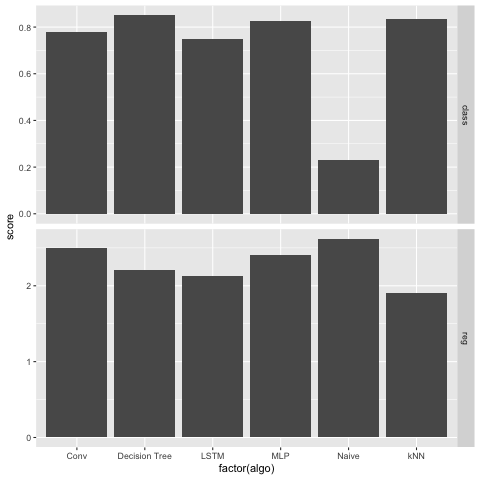

In [35]:
%%R -i RESULTS_FILE

library(tidyverse)

# Processing
csv <- read.csv(RESULTS_FILE)

indep_models <- csv %>% filter(type == 'per_output')

joint_models <- csv %>% filter(type == 'joint')
to_keep <- joint_models %>% 
                group_by(algo, type, algo_instance_reg, algo_instance_class) %>%
                summarize(train_score = mean(train_score)) %>%
                group_by(algo) %>%
                filter(train_score == max(train_score)) %>% data.frame()
print(to_keep)

joint_models <- semi_join(joint_models, to_keep, by=c("algo","algo_instance_reg","algo_instance_class")) %>%
                distinct()

all_models <- rbind(indep_models, joint_models)

# Plotting
to_plot <- all_models %>%
            select(algo, metric, test_score) %>%
            group_by(algo, metric) %>%
            summarize(score = mean(test_score)) %>%
            as.data.frame
print(to_plot)

to_plot$metric <- factor(to_plot$metric)

p <- ggplot(to_plot, aes(x=factor(algo), y=score)) +
    geom_bar(stat='identity') +
    facet_grid(metric~., scales='free')
p
